### Setup

* Measurements $(x_i,y_i,z_i)$ for $i=1:m$ where $m$ is the number of microphones. For some of the microphone there might not be measurements, which we indicate by $x_i=y_1=z_i=?$
* Redundancy: $x_i^2+y_i^2+z_i^2 = 1$ thus there are only two degrees of freedom. A simple reduction to two is $ x \to x/z$, $y \to y/z$
* Over-determined system: We choose $d=2,3,4$ the number of PCA coordinates to use. 

We want to solve for two sets of variables: the coefficients in front of the $d$ vectors, and the values corresponding to unknown entries in $x$. Assuming we reduced from 3 to 2 coordintes per array, lets indicate the missing coordinates by $u_i,v_i$ and indicate the combined vector by $\vec{U} = \{(x_1,y_1),\ldots,(x_k,y_k),(u_{k+1},v_{k+1}),\ldots,(u_m,v_m)\}$

We want an affine transformation which can be described by a matrix and a shift vector.

$$\vec{r} = \vec{s} + M \vec{U}$$ ( is this correct, or should it be,) - C

$$\vec{r} = M (\vec{U} - \vec{s})$$ - C

(where s is the nan mean of the measurement matrix. r is the PCA space point. M is the PCA matrix. U is the measurement vector.) - C

Here $M$ and $\vec{s}$ are known. The unknowns are the last $m-k$ coordinates of $U$ and the vector $\vec{r}$

### Solving
As this system is not linear, we can't solve in a single step, instead, we solve using two-step iterations.

0. **init** set the unknown coordinates $(u_i,v_i)$ to their mean value.
1. **update $\vec{r}$** using the fully defined $\vec{U}$
2. **update unknown measurements** update the unknown coordinates of $\vec{U}$ according to the current value of $\vec{r}$.

Steps 1,2 are repeated until convergence to some tolerance $\epsilon$.


In [5]:
import numpy as np
import pickle
import sys
from numpy import linalg as LA
from sklearn.cluster import KMeans
sys.path.append('/home/ardelalegre/SoundMapping/Analysis/Util')
from get_time_interval_matrix_data import get_time_interval_matrix_data
from PCA import get_cdata
from PCA import get_eigen_vectors
from PCA import project_to_eigen_vectors
from Plot import plot_data
import matplotlib.pyplot as plt

In [2]:
training_data = get_time_interval_matrix_data('Sep 29 2020 11:00AM', 'Sep 30 2020 05:00PM')

In [3]:
training_data.shape

(3300976, 19)

In [7]:
training_data[0,0]

1601402405.7724

### Running the same pca steps for non transformed data

In [17]:
training_data_mean = np.nanmean(training_data,axis = 0,keepdims = True)

/home/ardelalegre/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [18]:
training_data_mean

array([[ 1.60145091e+09, -1.91834520e-01,  1.74353581e-01,
         7.61226746e-01, -1.46510852e-01, -1.13185729e-01,
         7.05655222e-01, -1.83930866e-01,  4.69523846e-01,
         6.08664179e-01,  2.92724281e-02, -1.65958577e-01,
         8.04998712e-01,             nan,             nan,
                    nan,  7.15029289e-02,  5.16866813e-01,
         6.49699602e-01]])

### To calculate M, we remove the redundancy in the data. For each x, y, z triplet, we divide x and y by z

### The problem is that sometimes the z values are 0. This leads to the infinity values in the transformed data.

### Find x and y values when z = 0. If they are 0 too, we discard them or ignore them?

In [20]:
zero_triplets = np.where(training_data[:, 3] == 0)

In [21]:
zero_triplets

(array([  11033,   11034,   11035, ..., 3269359, 3269360, 3269361]),)

In [23]:
type(zero_triplets[0])

numpy.ndarray

In [25]:
where_z_array0_is_zero = training_data[zero_triplets[0]]

In [26]:
where_z_array0_is_zero.shape

(143989, 19)

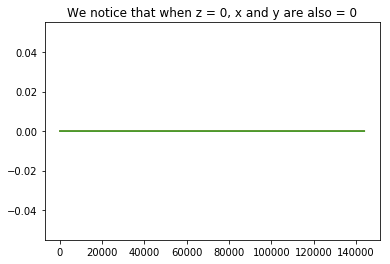

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(where_z_array0_is_zero[:,1:4])
ax.set_title('We notice that when z = 0, x and y are also = 0');

In [6]:
data = np.zeros((training_data.shape[0], 12))

In [13]:
z_zero

1

In [8]:
data[:, 0] = training_data[:, 1]/training_data[:, 3]
data[:, 1] = training_data[:, 2]/training_data[:, 3]
data[:, 2] = training_data[:, 4]/training_data[:, 6]
data[:, 3] = training_data[:, 5]/training_data[:, 6]
data[:, 4] = training_data[:, 7]/training_data[:, 9]
data[:, 5] = training_data[:, 8]/training_data[:, 9]
data[:, 6] = training_data[:, 10]/training_data[:, 12]
data[:, 7] = training_data[:, 11]/training_data[:, 12]
data[:, 8] = training_data[:, 13]/training_data[:, 15]
data[:, 9] = training_data[:, 14]/training_data[:, 15]
data[:, 10] = training_data[:, 16]/training_data[:, 18]
data[:, 11] = training_data[:, 17]/training_data[:, 18]

/home/ardelalegre/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/ardelalegre/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/ardelalegre/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ardelalegre/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ardelalegre/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/ardelalegre/.local/lib/python3.5/site-packages/ipykernel_lau

In [14]:
data_mean = np.nanmean(data,axis = 0,keepdims = True)

/home/ardelalegre/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [19]:
data_sum = np.nansum(data,axis = 0,keepdims = True)
data_sum

array([[-487490.69083365,  611234.18102133,             -inf,
                    -inf,              inf,              inf,
         177646.12826065, -487741.80342168,       0.        ,
              0.        ,  215612.17720065, 1194704.94583223]])

In [16]:
data.shape

(3300976, 12)

In [15]:
data_mean

array([[-0.36722186,  0.46043659,        -inf,        -inf,         inf,
                inf,  0.08109052, -0.22264057,         nan,         nan,
         0.15068839,  0.83496287]])

In [ ]:
cdata=np.nan_to_num(tmp)


dimensions = cdata.shape[1]
n=cdata.shape[0]
block_size=10000

# calculate covariance matrix
outters = np.zeros((dimensions, dimensions))
for j in range(n):
    outters += np.outer(cdata[j,:], cdata[j,:])

_cov = outters/n

#eigen values
eigen_values, eigen_vectors = LA.eig(_cov)

In [ ]:
# array_sum = np.sum(cdata)
bool_nan = np.isnan(cdata)
a = np.where(bool_nan ==True)

In [ ]:
a

In [ ]:
outters

In [ ]:
_cov

### SVDImpute

SVDImpute is a method for learning the matrix $M$ from a large set of vectors $\bf{U}$, which contains measurement vector where some of the coordinates might be missing.
Here we iteration between:

1. Estimating $\vec{s}$ and $\vec{M}$
2. Estimating $\vec{r}$ and the unknown components of the vectors in $\vec{U}$